In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import torch.nn.functional as F

In [2]:
#%%
 
# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column
 
# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]

# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]

# %%

# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]
outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
scaler = StandardScaler()

# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
#shape[(24, 4794, 1) (24, 4794, 1) (4794, 5) (24, 4794, 1)]

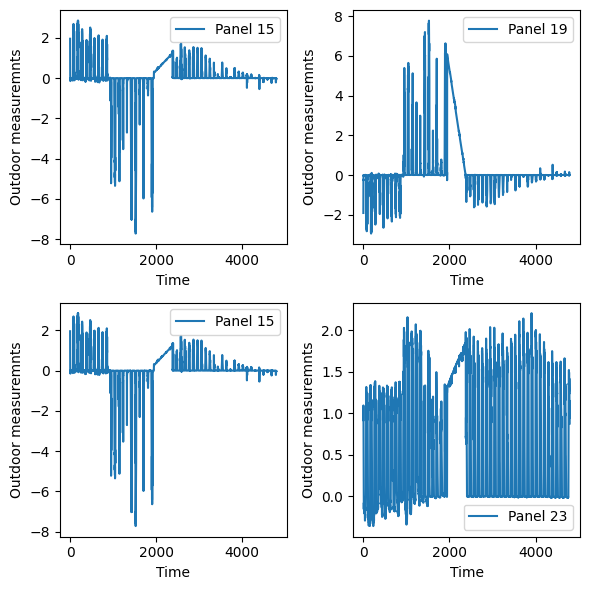

In [50]:
import matplotlib.pyplot as plt

x = range(outdoor_panels_power.shape[1])
panels_to_plot = [15, 19, 15, 23]

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i in range(2):
    for j in range(2):
        panel_idx = panels_to_plot[i * 2 + j]
        axs[i, j].plot(x, outdoor_panels_power[panel_idx], label=f'Panel {panel_idx}')
        axs[i, j].set_xlabel('Time')
        axs[i, j].set_ylabel('Outdoor measuremnts')
        axs[i, j].legend()

plt.tight_layout()
plt.savefig('underzeros.png')
plt.show()


In [59]:
time_series_1_sun.shape








# Calculate the average for time_series_1_sun
time_series_1_sun_average = np.zeros((6, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i + 1) % 4 == 0:
        # Take the mean of the last 4 time steps
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i - 3:i + 1], axis=0)
        j += 1

# Calculate the average for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((6, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i + 1) % 4 == 0:
        # Take the mean of the last 4 time steps
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i - 3:i + 1], axis=0)
        k += 1

# Calculate the average for outdoor_panels_power
outdoor_panels_power_average = np.zeros((6, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i + 1) % 4 == 0:
        # Take the mean of the last 4 time steps
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i - 3:i + 1], axis=0)
        # Set negative values to 0
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions] * 6, axis=0)

In [60]:

# Smoothing the outdoor_panels_power_average using savgol_filter
smoothed_series_1 = np.zeros((4794, 1))
for i in range(outdoor_panels_power_average.shape[0]):
    time_series_1 = outdoor_panels_power_average[i, :, 0]
    # Apply Savitzky-Golay filter to smooth the time series
    smoothed_series_1 = savgol_filter(time_series_1, 60, 3)
    # Set negative values to 0
    smoothed_series_1[smoothed_series_1 < 0] = 0
    outdoor_panels_power_average[i, :, 0] = smoothed_series_1



# Smoothing the time_series_1_sun_average using savgol_filter
smoothed_series_1 = np.zeros((4794, 1))
for i in range(time_series_1_sun_average.shape[0]):
    time_series_1 = time_series_1_sun_average[i, :, 0]
    # Apply Savitzky-Golay filter to smooth the time series
    smoothed_series_1 = savgol_filter(time_series_1, 60, 3)
    # Set negative values to 0
    smoothed_series_1[smoothed_series_1 < 0] = 0
    time_series_1_sun_average[i, :, 0] = smoothed_series_1
    

In [61]:
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use CUDA device if available
    print('CUDA is available')
else:
    device = torch.device('cpu')  # Use CPU if CUDA is not available


In [62]:
#convert out time series intot tensors
time_series_1_sun_average = torch.from_numpy(time_series_1_sun_average).float().to(device)
outdoor_panels_power_average = torch.from_numpy(outdoor_panels_power_average).float().to(device)
outdoor_conditions_stacked= torch.from_numpy(outdoor_conditions_stacked).float().to(device)
 

In [63]:
# THE MODEL
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers

        # Define LSTM layers
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True))
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True))

        # Define Highway layers
        self.highway_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.highway_layers.append(nn.Linear(hidden_dim * 2, hidden_dim * 2))

        # Define fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # Fully connected layer 1
        self.fc2 = nn.Linear(64, 32)  # Fully connected layer 2
        self.fc3 = nn.Linear(32, output_dim)  # Fully connected layer 3

        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

    def forward(self, x):
        # Iterate through LSTM layers
        for i in range(self.num_layers):
            if i == 0:
                lstm_output, _ = self.lstm_layers[i](x)  # Apply the first LSTM layer
            else:
                lstm_output, _ = self.lstm_layers[i](lstm_output)  # Apply subsequent LSTM layers

            highway_input = lstm_output + F.relu(self.highway_layers[i](lstm_output))  # Apply the highway transformation
            lstm_output = lstm_output + highway_input  # Combine LSTM output with the highway input
        
        # Apply fully connected layers
        output = self.fc1(lstm_output)  # Apply fully connected layer 1
        output = F.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc2(output)  # Apply fully connected layer 2
        output = F.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc3(output)  # Apply fully connected layer 3
        
        return output



In [64]:
input_dim = 6  # number of features in the outdoor conditions and the indoor measurements
hidden_dim = 128
output_dim = 1  # the number of features in the output
num_epochs = 150
num_layers = 4
learning_rate = 0.001
Fold = 0
kf = KFold(n_splits=6)

mse_scores = []
 
Predictions=np.zeros((6, 4794, 1)) 
Test=np.zeros((6, 4794, 1))
for train_index, test_index in kf.split(time_series_1_sun_average): 
    model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)# Initialize the LSTM model
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare training and testing data
    train_input = torch.cat([time_series_1_sun_average[train_index], outdoor_conditions_stacked[train_index]], dim=2)
    train_target = outdoor_panels_power_average[train_index]
    test_input = torch.cat([time_series_1_sun_average[test_index], outdoor_conditions_stacked[test_index]], dim=2)
    test_target = outdoor_panels_power_average[test_index]

     
    for epoch in range(num_epochs):
        model.train() # Set the model to training mode
        outputs = model(train_input)
        outputs = outputs.view(5, 4794, 1)
        loss = criterion(outputs, train_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sample_input = test_input
        predictions = model(sample_input)
        mse = F.mse_loss(predictions, test_target)
        mse_scores.append(mse.item())
        print(mse.item())
        Predictions[Fold]= predictions.numpy()
        Test[Fold]=test_target.numpy()
    Fold += 1
    
print(np.mean(mse_scores))



torch.Size([5, 4794, 6])
0.6581932306289673
torch.Size([5, 4794, 6])
2.1283512115478516
torch.Size([5, 4794, 6])
0.620316743850708
torch.Size([5, 4794, 6])
0.2562921643257141
torch.Size([5, 4794, 6])
1.4327343702316284
torch.Size([5, 4794, 6])
0.4047739803791046
0.9167769501606623


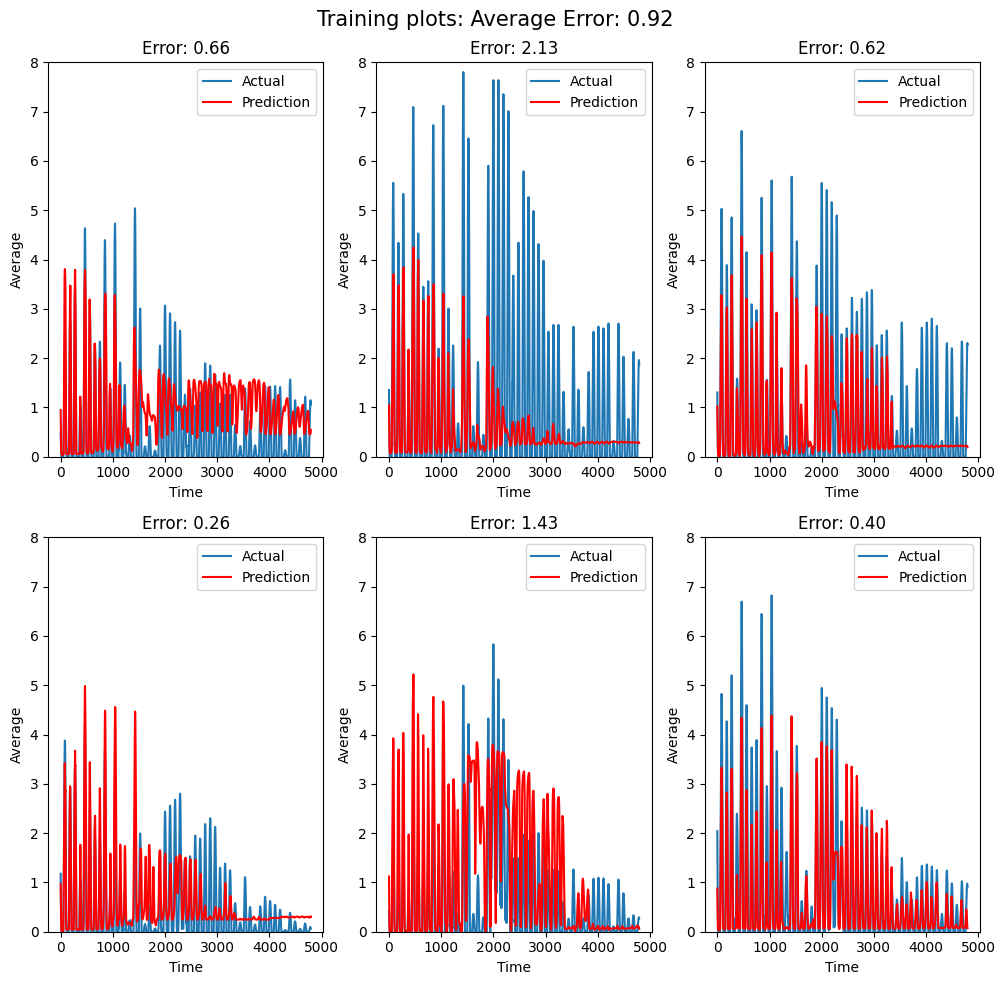

In [70]:
x = range(Predictions.shape[1]) 
fig, axs = plt.subplots(2, 3, figsize=(10, 10))


for i, axs in enumerate(axs.flat):
    axs.plot(x, Test[i], label='Actual')
    axs.plot(x, Predictions[i], label='Prediction', color='red')
    axs.set_xlabel('Time')
    axs.set_ylabel('Average')
    axs.legend()
    axs.set_ylim(0, 8)  # Set the y-axis limits from 0 to 14 for each subplot
    axs.set_title(f'Error: {mse_scores[i]:.2f}')

average_error = np.mean(mse_scores)
fig.suptitle(f'Training plots: Average Error: {average_error:.2f}', fontsize=15)
plt.savefig('training.pdf')
plt.tight_layout()
plt.show()